<a href="https://colab.research.google.com/github/kretchmar/CS339_2023/blob/main/NaiveBayes3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Naive Bayes

Matt Kretchmar <p>
January 2023 <p>

### Purpose
This notebook implements the Naive Bayes algorithm in a couple of different ways:

* 1D simple gaussian mixture of two categories, using hand-built code
* same 1D dataset using scikit model



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd


## Make 1D Data

Here we create a 1D dataset using numpy

In [ ]:
def createGaussian ( mu, sig, n):
  '''
  This function creates and returns n samples from a gaussian distribution
  of mean=mu and standard deviation=sig
  '''
  return np.random.normal(mu,sig,n)

def make_1D_data ( ):
  cat1 = createGaussian(1.0,1.0,100)
  cat2 = createGaussian(2.5,2.0,150)
  df1 = pd.DataFrame(data=cat1,columns=['x'])
  df1['Class'] = 0
  df2 = pd.DataFrame(data=cat2,columns=['x'])
  df2['Class'] = 1
  df = df1.append(df2)
  return df



            x  Class
0    1.668060      0
1    1.642462      0
2    0.008005      0
3    2.813572      0
4    1.336059      0
..        ...    ...
145  2.863748      1
146  4.111156      1
147  2.261788      1
148  1.700730      1
149  4.172675      1

[250 rows x 2 columns]


Text(0, 0.5, 'Frequency')

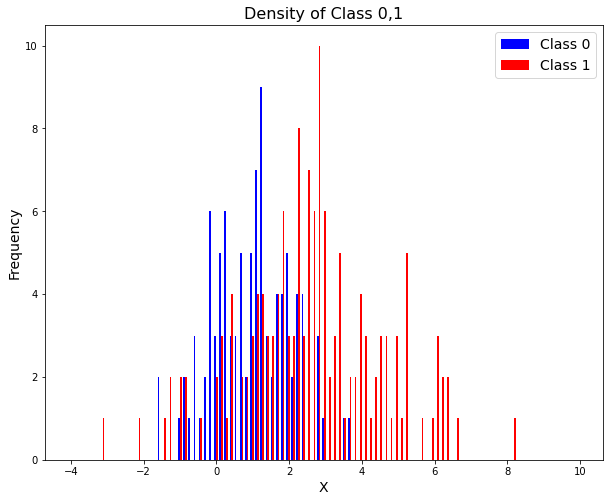

In [ ]:
data = make_1D_data()
print(data)
#data['x'].hist(by=data['Class'])
fig,ax = plt.subplots(figsize=(10,8))

heights_1, bins_1 = np.histogram(data[data.Class==1]['x'],bins=np.linspace(-4,10,num=100))
heights_0, bins_0 = np.histogram(data[data.Class==0]['x'],bins=bins_1)

#data[data.Class==0].hist(column='x',bins=50,color='teal',alpha=0.5)
#data[data.Class==1].hist(column='x',bins=50,color='blue',alpha=0.5)
#plt.show()

width = (bins_1[1]-bins_1[0]) / 3
ax.bar(bins_0[:-1],heights_0,width=width,facecolor='blue')
ax.bar(bins_1[:-1]+width,heights_1,width=width,facecolor='red')
plt.title('Density of Class 0,1',fontsize=16)
plt.legend(['Class 0','Class 1'],fontsize=14)
plt.xlabel('X',fontsize=14)
plt.ylabel('Frequency',fontsize=14)


In [ ]:
def buildRandTestSet ( df, percent=0.2 ):
  '''
  The function takes a dataset and helps break it into a testing set
  and a training set.  
  PARAMETERS:
  df - a pandas dataframe with one column named "Class" which
  is the target output category.  
  The columns are attributes and the rows are samples.  

  percent - a percentage between 0 and 1 which indicates how
  much of the data should be used for the test set.  The
  remaining data is used for the training set.

  RETURN VALUE: dfTrain, dfTest
  The function returns two pandas dataframes which the same
  structure as the input dataframe.  The input dataframe is
  partitioned into a test set comprising "percent"% of the
  rows randomly selected from the original dataframe. The training
  set is the remaining 1-percent % of the data rows.  
  Note that the input dataframe is first sorted by the "label" 
  columns and the percentage is taken from each category (each
  unique label value).  That way the testing and training set
  each have approximately the same percentage of samples with
  each label value.  
  '''
  # initialize dfTest and dfTrain to None 
  dfTest = None
  dfTrain = None

  # find unique labels and sort dataset by labels
  vals = df.Class.unique()
  df2 = df.sort_values(by=['Class'])

  # for each label, we will select percent of the rows for testing, 
  # keep the rest for training
  for val in vals:
    # get subset of rows with this label val
    df3 = df2.loc[df2['Class'] == val]
    count = len(df3)
    # random permutation of all these row indices
    shuffle = np.random.permutation(count)
    # select set of indices for test set rows 
    # and training set rows
    testIndices = shuffle[:int(count*percent)]
    trainIndices = shuffle[int(count*percent):]

    testSetTemp = df3.iloc[testIndices]
    trainSetTemp = df3.iloc[trainIndices]

    # append and build test and training sets
    if dfTest is None:
      dfTest = testSetTemp
      dfTrain = trainSetTemp
    else:
      dfTest = dfTest.append(testSetTemp)
      dfTrain = dfTrain.append(trainSetTemp)

  return dfTrain,dfTest



In [ ]:
trainSet,testSet = buildRandTestSet(data,0.3)
print(len(trainSet))
print(trainSet)
print(len(testSet))
print(testSet)

175
            x  Class
83   0.047492      0
96  -0.511922      0
81   0.231462      0
88   1.355712      0
46  -0.157855      0
..        ...    ...
89   2.804419      1
145  2.863748      1
110  1.660560      1
140  0.821797      1
5    1.101704      1

[175 rows x 2 columns]
75
            x  Class
36   0.999104      0
52   2.250743      0
38   2.452622      0
34   1.139256      0
0    1.668060      0
..        ...    ...
136  2.328771      1
43   1.240351      1
77   5.232576      1
109  3.159318      1
71   2.791456      1

[75 rows x 2 columns]


## Parameter Estimation
n = sample size <p>
mean = sample mean <p>
sigma = sample standard deviation<p>


In [ ]:
def estimateNormal (data):
  '''
  data is a numpy array of samples from a single category
  returns triplet (n,mu,sig)
  '''
  n = len(data)
  mu = data.mean()
  sig = data.std()
  return (n,mu,sig)
  

In [ ]:
data0 = trainSet[trainSet.Class == 0].x.to_numpy()
data1 = trainSet[trainSet.Class == 1].x.to_numpy()
#print(data0)
#print(data1)
(n0,mu0,sig0) = estimateNormal(data0)
(n1,mu1,sig1) = estimateNormal(data1)
print("Class 0\n")
print("\tSample Size: {0:5d}".format(n0))
print("\tSample Mean: {0:5.2f}".format(mu0))
print("\tSample Sdt:  {0:5.2f}".format(sig0))
print("Class 1\n")
print("\tSample Size: {0:5d}".format(n1))
print("\tSample Mean: {0:5.2f}".format(mu1))
print("\tSample Sdt:  {0:5.2f}".format(sig1))




Class 0

	Sample Size:    70
	Sample Mean:  1.01
	Sample Sdt:   1.09
Class 1

	Sample Size:   105
	Sample Mean:  2.74
	Sample Sdt:   2.11


## Bayesian Compuations

Functions to compute
* prior
* likelihood
* evidence

In [ ]:
import scipy.stats

def compute_prior (ns,cat):
  '''
  ns is a list of sample sizes
  Computes ni/sum(n)
  where ni is the cat from ns
  '''
  return ns[cat] / ns.sum()

def compute_likelihood (x,mu,sig):
  '''
  Computes Bayesian Likelihood
  '''
  return scipy.stats.norm(mu,sig).pdf(x)

def compute_evidence (x, mus, sigs,priors):
  '''
  Compute Bayesian evidence where
  mus, and sigs are both a list of C means/stds where C is the number of categories
  '''
  total = 0
  for i in range(len(mus)):
    total += compute_likelihood(x,mus[i],sigs[i]) * priors[i]

  return total

def compute_posterior (x,ns,mus,sigs):
  '''
  Computes the Bayesian Postieriors for each category
  mus and sigs are the mu/std for each category
  Returns a numpy array of prob for each category
  '''
  priors = np.zeros((len(mus),1))
  for c in range(len(mus)):
    priors[c] = compute_prior(ns,c)

  evidence = compute_evidence(x,mus,sigs,priors)
  posteriors = np.zeros(len(mus))

  for c in range(len(mus)):
    likelihood = compute_likelihood(x,mus[c],sigs[c])
    posteriors[c] = likelihood * priors[c] / evidence

  return posteriors




In [ ]:
x = 1
ns = np.array((n0, n1))
mus = np.array((mu0,mu1))
sigs = np.array((sig0,sig1))
posts = compute_posterior(x,ns,mus,sigs)
print(posts)


[0.64394372 0.35605628]


In [ ]:

print("x = ",x)
prior0 = compute_prior(ns,0)
prior1 = compute_prior(ns,1)
print("prior0: ",prior0)
print("prior1: ",prior1)

likelihood0 = compute_likelihood(x,mus[0],sigs[0])
likelihood1 = compute_likelihood(x,mus[1],sigs[1])
print("likelihood0: ",likelihood0)
print("likelihood1: ",likelihood1)

priors = np.array((prior0,prior1))
evidence = compute_evidence(x,mus,sigs,priors)
print("evidence: ",evidence)

post0 = prior0 * (likelihood0)/evidence
post1 = prior1 * (likelihood1)/evidence
print("post0: ",post0)
print("post1: ",post1)




x =  1
prior0:  0.4
prior1:  0.6
likelihood0:  0.3654790194436296
likelihood1:  0.13472305661787534
evidence:  0.22702544174817707
post0:  0.6439437212487032
post1:  0.3560562787512967


### Plot Posteriors


In [ ]:
x = np.linspace(-3,12,300)
y0 = np.zeros(300)
y1 = np.zeros(300)

for i in range(len(x)):
  posts = compute_posterior(x[i],ns,mus,sigs)
  y0[i] = posts[0]
  y1[i] = posts[1]



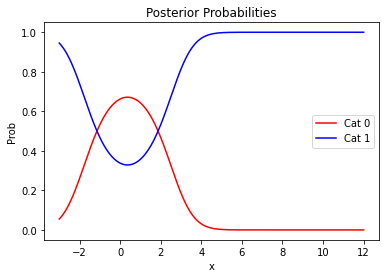

In [ ]:
plt.figure()
plt.plot(x,y0,c='red')
plt.plot(x,y1,c='blue')
plt.title('Posterior Probabilities')
plt.xlabel('x')
plt.ylabel('Prob')
plt.legend(['Cat 0','Cat 1'])
plt.show()


### Compute Accuracy on Testset


In [ ]:
y = np.zeros(len(testSet)).astype(int)
z = np.zeros(len(testSet)).astype(int)
for i in range(len(testSet)):
  x = testSet.iloc[i,0]
  y[i] = testSet.iloc[i,1].astype(int)
  posts = compute_posterior(x,ns,mus,sigs)
  if posts[0] >= 0.5:
    z[i] = 0
  else:
    z[i] = 1
  print("Test ({0:5.2f},{1:d}): z={2:d}".format(x,y[i],z[i]))


d = len(y)
count_incorrect = np.sum(z != y)
accuracy = (d-count_incorrect) / d
print("Num Test Samples: {0:d}".format(d))
print("Num Errors:       {0:d}".format(count_incorrect))
print("Accuracy:         {0:4.2f}".format(accuracy))




Test ( 1.00,0): z=0
Test ( 2.25,0): z=1
Test ( 2.45,0): z=1
Test ( 1.14,0): z=0
Test ( 1.67,0): z=0
Test (-0.67,0): z=0
Test (-0.06,0): z=0
Test ( 0.81,0): z=0
Test ( 0.28,0): z=0
Test (-1.57,0): z=1
Test ( 1.95,0): z=1
Test ( 1.64,0): z=0
Test ( 1.19,0): z=0
Test ( 1.24,0): z=0
Test ( 1.07,0): z=0
Test (-0.07,0): z=0
Test ( 0.96,0): z=0
Test ( 0.48,0): z=0
Test ( 1.41,0): z=0
Test (-0.09,0): z=0
Test ( 3.58,0): z=1
Test ( 1.95,0): z=1
Test ( 1.25,0): z=0
Test ( 2.06,0): z=1
Test ( 0.77,0): z=0
Test ( 1.72,0): z=0
Test ( 0.12,0): z=0
Test ( 0.99,0): z=0
Test (-0.26,0): z=0
Test ( 1.38,0): z=0
Test ( 2.53,1): z=1
Test (-0.42,1): z=0
Test ( 1.06,1): z=0
Test ( 1.15,1): z=0
Test ( 4.51,1): z=1
Test ( 3.11,1): z=1
Test ( 3.95,1): z=1
Test ( 2.31,1): z=1
Test ( 0.08,1): z=0
Test ( 2.82,1): z=1
Test (-2.11,1): z=1
Test ( 2.62,1): z=1
Test ( 3.05,1): z=1
Test ( 2.00,1): z=1
Test ( 1.17,1): z=0
Test ( 6.27,1): z=1
Test ( 3.54,1): z=1
Test ( 6.08,1): z=1
Test ( 3.21,1): z=1
Test ( 4.05,1): z=1


## Use scikit Model on 1D data

In [ ]:
from sklearn.naive_bayes import CategoricalNB
clf = GaussianNB()

# Note that X must be in the form of (n,m) where n is the number of 
# samples and m is the number of attributes (dimensionality)
# Here we have n = | trainSet |
# m = 1 since there is only 1 value in each x (1D data)
X = trainSet.x.to_numpy()
n = len(X)
X = X.reshape((n,1))
Y = trainSet.Class.to_numpy().astype(int)
clf.fit(X,Y)



GaussianNB()

In [ ]:
Xtest = testSet.x.to_numpy()
n = len(Xtest)
Xtest = Xtest.reshape((n,1))
z = clf.predict(Xtest)
print(z)

y = testSet.Class.to_numpy().astype(int)
d = len(y)
count_incorrect = np.sum(z != y)
accuracy = (d-count_incorrect) / d
print("Num Test Samples: {0:d}".format(d))
print("Num Errors:       {0:d}".format(count_incorrect))
print("Accuracy:         {0:4.2f}".format(accuracy))



[0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 1 1 1
 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1
 1]
Num Test Samples: 75
Num Errors:       16
Accuracy:         0.79
